In [261]:
## Miscelaneous
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from tqdm import tqdm
import pickle as pkl

import pybedtools
from pybedtools import BedTool

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.preprocessing.utils import *
from chromograph.plotting.marker_plot import marker_plot
from chromograph.plotting.peak_annotation_plot import plot_peak_annotation_wheel
from chromograph.pipeline import config

import cytograph as cg
from cytograph.plotting.colors import colorize
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species

import fisher

from typing import *

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as stats
import scipy
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.spatial.distance import pdist, cdist

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

config = config.load_config()

In [3]:
f_peaks = '/proj/DEV_ATAC/Build_20210203/All/All_peaks.agg.loom'
f_prom = '/proj/DEV_ATAC/Build_20210203/All/All_prom.agg.loom'

ch1_peaks = '/proj/DEV_ATAC/Build_20210203/All/All_peaks_ch1.agg.loom'
ch1_prom = '/proj/DEV_ATAC/Build_20210203/All/All_prom_ch1.agg.loom'

In [27]:
with loompy.connect(f_prom, 'r') as ds:
    print(ds.ra.keys())
    print(ds.ra.loc[:10])
    print(ds.layers.keys())
    
    for x in ds.ra:
        print(x)
        print(ds.ra[x][:10])

['Accession', 'BPs', 'Gene', 'loc']
['chr17:3205539-3208538' 'chr1:158330532-158333531'
 'chr7:144067811-144070810' 'chr2:166886487-166889486'
 'chr19:54814468-54817467' 'chr6:52762570-52765569'
 'chr1:248561773-248564772' 'chr14:19873142-19876141'
 'chr11:55793556-55796555' 'chr1:15657869-15660868']
['', 'enrichment']
Accession
['ENSG00000172146.2' 'ENSG00000158485.10' 'ENSG00000221933.3'
 'ENSG00000163092.19' 'ENSG00000167633.18' 'ENSG00000244067.2'
 'ENSG00000182783.5' 'ENSG00000165762.3' 'ENSG00000186113.1'
 'ENSG00000215695.1']
BPs
[2999 2999 2999 2999 2999 2999 2999 2999 2999 2999]
Gene
['OR1A1' 'CD1B' 'OR2A25' 'XIRP2' 'KIR3DL1' 'GSTA2' 'OR2T29' 'OR4K2'
 'OR5D14' 'RSC1A1']
loc
['chr17:3205539-3208538' 'chr1:158330532-158333531'
 'chr7:144067811-144070810' 'chr2:166886487-166889486'
 'chr19:54814468-54817467' 'chr6:52762570-52765569'
 'chr1:248561773-248564772' 'chr14:19873142-19876141'
 'chr11:55793556-55796555' 'chr1:15657869-15660868']


In [52]:
os.system(f'rm {ch1_peaks}')
os.system(f'rm {ch1_prom}')

for in_file, out_file in [[f_peaks, ch1_peaks], [f_prom, ch1_prom]]:
    print(f'Creating: {out_file}')
    with loompy.connect(in_file, 'r') as ds:
        try:
            X = np.where(ds.ra.Chr == 'chr1')[0]
        except:
            CHR = np.array([x.split(':')[0] for x in ds.ra.loc])
            X = np.where(CHR == 'chr1')[0]
            
        with loompy.new(out_file) as dsout:
            dsout[''] = ds[''][X,:]
            if 'CPM' in ds.layers:
                dsout['CPM'] = ds['CPM'][X,:]

            dsout.ca = ds.ca

            ## Transfer row attr
            for k in ds.ra:
                dsout.ra[k] = ds.ra[k][X]

Creating: /proj/DEV_ATAC/Build_20210203/All/All_peaks_ch1.agg.loom
Creating: /proj/DEV_ATAC/Build_20210203/All/All_prom_ch1.agg.loom


In [55]:
with loompy.connect(ch1_peaks) as ds_peaks:
    with loompy.connect(ch1_prom) as ds_prom:
        print(ds_peaks.shape)
        print(ds_prom.shape)
#         R = np.corrcoef(ds_peaks[''][:,:], ds_prom[''][:,:], rowvar=True)
        R = np.corrcoef(ds_peaks['CPM'][:,:])
        np.fill_diagonal(R,0)

(34596, 155)
(2041, 155)


In [67]:
R > 0.25
print(f'Total high correlation pairs: {np.sum(R > 0.25)/2}')
print(f'Mean high correlationp pairs per peak: {(np.sum(R > 0.25)/2)/R.shape[0]}')

Total high correlation pairs: 62625.0
Mean high correlationp pairs per peak: 1.8101803676725634


In [204]:
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return div0(np.dot(A_mA, B_mB.T), np.sqrt(np.dot(ssA[:, None],ssB[None])))

with loompy.connect(ch1_peaks) as ds_peaks:
    with loompy.connect(ch1_prom) as ds_prom:
        R = corr2_coeff(ds_peaks['CPM'][:,:], ds_prom['CPM'][:,:])

In [205]:
R > 0.25
print(f'Total high correlation pairs: {np.sum(R > 0.25)/2}')
print(f'Mean high correlationp pairs per peak: {(np.sum(R > 0.25)/2)/R.shape[0]}')

Total high correlation pairs: 1973590.0
Mean high correlationp pairs per peak: 57.04676841253324


(array([2.4760000e+03, 1.0730900e+05, 1.4248780e+06, 1.2028557e+07,
        3.5562566e+07, 1.7798728e+07, 3.1821410e+06, 4.3729900e+05,
        5.7966000e+04, 8.5160000e+03]),
 array([-0.8543264 , -0.66918631, -0.48404622, -0.29890613, -0.11376603,
         0.07137406,  0.25651415,  0.44165424,  0.62679433,  0.81193443,
         0.99707452]),
 <BarContainer object of 10 artists>)

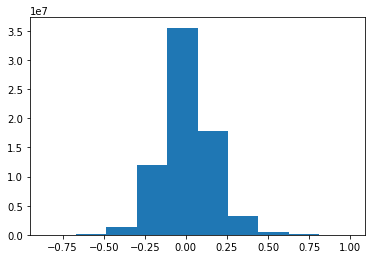

In [206]:
plt.hist(R.flatten())

In [207]:
# ## Calculating genomic distance

with loompy.connect(ch1_peaks) as ds_peaks:
    with loompy.connect(ch1_prom) as ds_prom:
        chrom = np.array([x.split(':') for x in ds_prom.ra.loc])[:,0]
        pos = np.array([x.split(':') for x in ds_prom.ra.loc])[:,1]
        pos = np.array([x.split('-') for x in pos], dtype=int)

        ds_prom.ra.Chrom = chrom
        ds_prom.ra.Start = pos[:,0]
        ds_prom.ra.End = pos[:,1]
        
        ds_peaks.ra.Start = ds_peaks.ra.Start.astype(int)
        ds_peaks.ra.End = ds_peaks.ra.End.astype(int)

In [208]:
## Calculating genomic distance
from scipy.spatial import cKDTree as KDTree

with loompy.connect(ch1_peaks) as ds_peaks:
    with loompy.connect(ch1_prom) as ds_prom:
        
        for ds in [ds_peaks, ds_prom]:
            if 'pos' not in ds.ra:
                pos = np.vstack((ds.ra.Start, ds.ra.End))
                ds.ra.pos = np.mean(pos, axis=0)
                
        
        ## Get distance matrix
        t1 = KDTree(ds_peaks.ra.pos.reshape((ds_peaks.shape[0],1)))
        t2 = KDTree(ds_prom.ra.pos.reshape((ds_prom.shape[0],1)))
        maxD = 500000
        ans = t1.sparse_distance_matrix(t2, maxD)


(array([ 56.,  27.,  76., 113.,  75.,  64.,  54.,  23.,   7.,   3.]),
 array([  0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162., 180.]),
 <BarContainer object of 10 artists>)

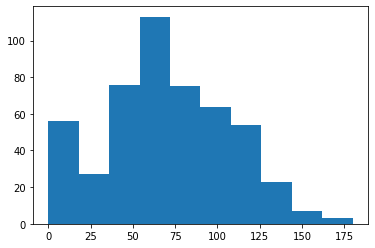

In [287]:
N = []
window_size = 500000
with loompy.connect(ch1_peaks) as ds_peaks:
    chromosome_size = int(np.max(ds_peaks.ra.pos))
    for x_min in range(0, chromosome_size, window_size):
        x_max = min(x_min + window_size, chromosome_size)
        X = (ds_peaks.ra.pos > x_min) & (ds_peaks.ra.pos < x_max)
        N.append(np.sum(X))
    
plt.hist(N)

In [209]:
valid = ans > 0
np.sum(valid)

333043

0.006305123161707311


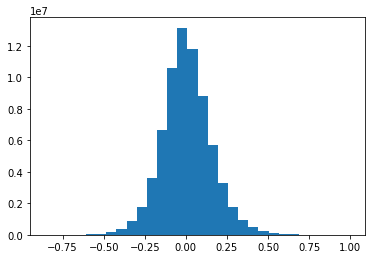

In [212]:
plt.hist(R.flatten(), bins=30);
print(R.mean())

In [194]:
np.sum(R[valid.nonzero()]>0.25)

674912

0.030784238594618717


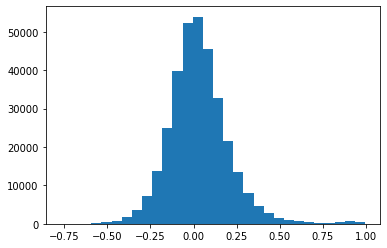

In [213]:
plt.hist(R[valid.nonzero()], bins=30);
print(R[valid.nonzero()].mean())
# plt.hist(R[valid.indices])

In [230]:
R2 = np.zeros(R.shape)
R2[valid.nonzero()] = R[valid.nonzero()]

In [659]:
## Define functions

def rho_matrix(dist_matrix, dist_param, s, xmin=1000):
    out = (1-div0(xmin, dist_matrix)**s) * dist_param
    out[np.isnan(out)] = 0
    return np.clip(out, 0, None)


0.0

In [741]:
from sklearn.covariance import GraphicalLassoCV, empirical_covariance, shrunk_covariance
s = 0.75
dist_param = 1

In [763]:
window_size = 500000

x_min = 500000
x_max = x_min + window_size

with loompy.connect(ch1_peaks) as ds_peaks:
    chromosome_size = int(np.max(ds_peaks.ra.pos))
    X = (ds_peaks.ra.pos > x_min) & (ds_peaks.ra.pos < x_max)
    mat = ds_peaks['CPM'][X,:]
    pos = ds_peaks.ra.pos[X]
    dist = cdist(pos.reshape(pos.shape[0],1), pos.reshape(pos.shape[0],1))
    logging.info(mat.shape)
    
#     cov = corr2_coeff(mat, mat)
#     np.fill_diagonal(cov,1e-4)

10:10:35 INFO     (50, 155)


/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:266: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.376e-03
  % (max_iter, d_gap), ConvergenceWarning)
10:20:19 INFO     Range of covariance: -0.378982284057377 - 1.0000000000000027


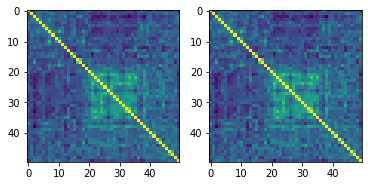

In [769]:
rho = rho_matrix(dist, dist_param, s, xmin=2000)
cov = corr2_coeff(mat, mat)
# np.fill_diagonal(cov,cov.diagonal()+1e-4)
# GLasso = GraphicalLasso(max_iter=1000).fit(cov);

mat -= mat.mean(axis=1).reshape(mat.shape[0],1)
mat /= mat.std(axis=1).reshape(mat.shape[0],1)

GLasso = GraphicalLasso(max_iter=1000).fit(mat.T);

fig, ax = plt.subplots(1,2)
ax[0].imshow(GLasso.covariance_)
ax[1].imshow(cov)
logging.info(f'Range of covariance: {np.min(GLasso.covariance_)} - {np.max(GLasso.covariance_)}')

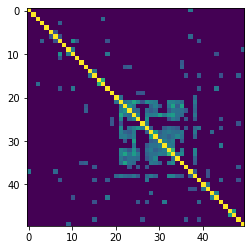

In [770]:
thresh = .25
X = GLasso.covariance_.copy()
X[X<thresh] = 0
plt.imshow(X)

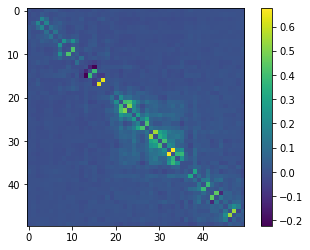

In [765]:
plt.imshow(GLasso.covariance_ * (1-rho))
plt.colorbar()

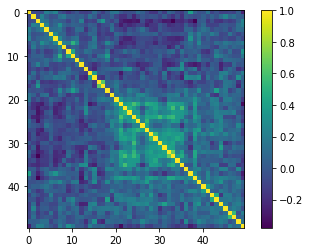

In [766]:
plt.imshow(GLasso.covariance_)
plt.colorbar()

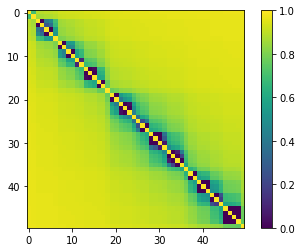

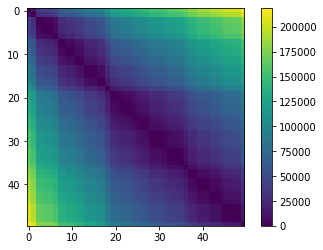

In [767]:
plt.imshow(rho)
plt.colorbar()

plt.figure()
plt.imshow(dist)
plt.colorbar()

(array([  40.,  188., 1980.,   59.,  116.,   84.,   20.,    8.,    2.,
           3.]),
 array([-0.01926951, -0.01109344, -0.00291737,  0.00525871,  0.01343478,
         0.02161085,  0.02978692,  0.037963  ,  0.04613907,  0.05431514,
         0.06249121]),
 <BarContainer object of 10 artists>)

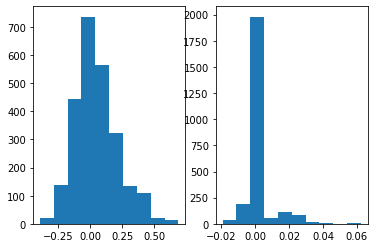

In [555]:
fig, ax = plt.subplots(1,2)
ax[0].hist(cov.flatten())
ax[1].hist(GLasso.covariance_.flatten())

In [452]:
import warnings

window_size = 500000

Co_acc = []
positions = []

with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    with loompy.connect(ch1_peaks) as ds_peaks:
        chromosome_size = int(np.max(ds_peaks.ra.pos))
        for x_min in range(0, chromosome_size, int(window_size/2)):
            x_max = min(x_min + window_size, chromosome_size)
            X = (ds_peaks.ra.pos > x_min) & (ds_peaks.ra.pos < x_max)

            if np.sum(X) > 1:
                try:
                    mat = ds_peaks['CPM'][X,:]
                    pos = ds_peaks.ra.pos[X]
                    dist = cdist(pos.reshape(pos.shape[0],1), pos.reshape(pos.shape[0],1))

#                     mat -= mat.mean(axis=1).reshape(mat.shape[0],1)
#                     mat /= mat.std(axis=1).reshape(mat.shape[0],1)

                    cov = corr2_coeff(mat, mat)
                    np.fill_diagonal(cov,1e-4)
                    GLasso = GraphicalLasso().fit(cov);

                    positions.append(X)
                    Co_acc.append(GLasso.covariance_)
                    
                except Exception as e:
                    logging.info(f'Error in sample: {x_min}:{x_max} with {np.sum(X)} features')
                    logging.info(e)

/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:266: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -4.965e-04
  % (max_iter, d_gap), ConvergenceWarning)
/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:266: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.234e-03
  % (max_iter, d_gap), ConvergenceWarning)
/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.284671797665421e-05, tolerance: 1.1188391967819176e-05
  check_random_state(None), False)
/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

In [501]:
with loompy.connect(ch1_peaks) as ds_peaks:
    X = sparse.dok_matrix((ds_peaks.shape[0], ds_peaks.shape[0]), dtype=np.float16)
    
    for mat, pos in zip(Co_acc, positions):
        loc = np.where(pos)[0]
        s = np.min(loc)
        end = np.max(loc)+1
        X[s:end,s:end] = mat[:,:]

(array([2.400000e+01, 3.028313e+06, 8.000000e+00, 2.500000e+01,
        9.000000e+00, 0.000000e+00, 0.000000e+00, 7.000000e+00,
        0.000000e+00, 2.700000e+01]),
 array([-1.135 , -0.4468,  0.2415,  0.9297,  1.617 ,  2.305 ,  2.994 ,
         3.682 ,  4.37  ,  5.06  ,  5.746 ], dtype=float16),
 <BarContainer object of 10 artists>)

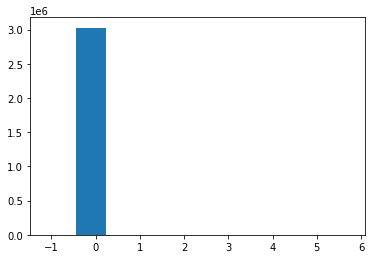

In [503]:
plt.hist(X.values())

(array([ 56.,  27.,  76., 113.,  75.,  64.,  54.,  23.,   7.,   3.]),
 array([  0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162., 180.]),
 <BarContainer object of 10 artists>)

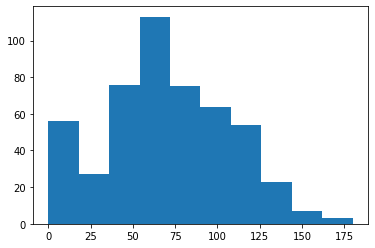

In [289]:
window_size = 500000
with loompy.connect(ch1_peaks) as ds_peaks:
    chromosome_size = int(np.max(ds_peaks.ra.pos))
    for x_min in range(0, chromosome_size, int(window_size/2)):
        x_max = min(x_min + window_size, chromosome_size)
        X = (ds_peaks.ra.pos > x_min) & (ds_peaks.ra.pos < x_max)
        mat = ds_peaks['CPM'][X,:]
        pos = ds_peaks.ra.pos[X]
        dist = cdist(pos.reshape(pos.shape[0],1), pos.reshape(pos.shape[0],1))
    
plt.hist(N)